In [ ]:
%pip install -U langchain langchain-core langchain-openai langchain-community python-dotenv
%pip install -U langchain-classic

In [ ]:
import random
from typing import TypedDict
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_openai import ChatOpenAI
from IPython.display import Image, display
from dotenv import load_dotenv
import os

load_dotenv()
api_key = os.getenv("API_KEY")
base_url = os.getenv("OPENAI_ENDPOINT")
model_name = "gpt-4o-mini"
temp=0.0

llm = ChatOpenAI(
    base_url=base_url,
    api_key=api_key,
    model=model_name,
    temperature=temp
)

## **Graph Workflow Concept: Nodes & Edges** 
- The concept is that we can build a workflow as a graph
  - Nodes are functions to be executed (i.e. invoked)
  - Edges specify the sequences between nodes and can be functions with branching conditions
- Each node function accept State object and return new State object (or dictionary with the State keys)
- Each edge function accepts State object and return  node name (string), including START or END nodes (keywords)
- The entire graph workflow can be compiled and invoked

In [4]:
# The State object is a common parameter between node functions
class State(TypedDict):
    input: int
    output: int
    

# We defined the nodes as function that takes State as parameter and exchange data through it
def node_a(state: State)->State:
    input_value = state['input']
    offset = random.randint(1,10)
    output =  input_value + offset
    print(
        f"NODE A:\n "
        f"->input:{input_value}\n " 
        f"->offset:{offset}\n "
        f"->output:{output}\n "
    )
    return State(output=output)

def node_b(state: State):
    input_value = state['output']
    offset = random.randint(1,10)
    output =  input_value + offset
    print(
        f"NODE B:\n "
        f"->input:{input_value}\n " 
        f"->offset:{offset}\n "
        f"->output:{output}\n "
    )
    return {"output": output}


In [6]:
# we then define the graph workflow (StateGraph)
workflow = StateGraph(state_schema=State)

# we add the nodes (functions)
workflow.add_node(node_a)
workflow.add_node(node_b)

# we add the edges (from/to tuples with the node names as strings)
# START and END are the special nodes
workflow.add_edge(START, "node_a")
workflow.add_edge("node_a", "node_b")
workflow.add_edge("node_b", END)

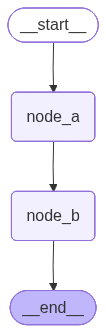

In [10]:
# We compile the graph workflow
graph = workflow.compile()

# we can display it as workflow diagram
display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

In [11]:
# finall we invoke it with the expected input dictionary to execute the functions
graph.invoke(
    input = {
        "input": 1,
    }, 
)

NODE A:
 ->input:1
 ->offset:4
 ->output:5
 
NODE B:
 ->input:5
 ->offset:8
 ->output:13
 


{'input': 1, 'output': 13}

## **Graph Workflow with LLM Calls**

In [15]:
class State(TypedDict):
    question:str
    response:str

def model(state: State):
    question = state["question"]
    response = llm.invoke([
        SystemMessage("You're a Pokémon specialist"),
        HumanMessage(question)
    ])

    return {"response": response.content}

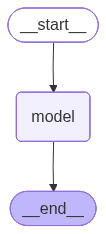

In [16]:
# Create
workflow = StateGraph(State)

# add the nodes
workflow.add_node("model", model)

# add the edges
workflow.add_edge(START, "model")
workflow.add_edge("model", END)

# compile
graph = workflow.compile()

# display
display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

In [17]:
# invoke
result = graph.invoke(
    input={
        "question": "What's the name of Ash's first pokémon?"
    }, 
)
result

{'question': "What's the name of Ash's first pokémon?", 'response': "Ash's first Pokémon is Pikachu. He received Pikachu from Professor Oak at the beginning of his journey in the Pokémon anime series."}


In [23]:
print(result["response"])

Ash's first Pokémon is Pikachu. He received Pikachu from Professor Oak at the beginning of his journey in the Pokémon anime series.
